In [1]:
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
!tar xf mmimdb-256.tar.gz -C ./data/mmimdb-256/

--2020-12-02 18:04:30--  http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  37.9MB/s    in 17s     

2020-12-02 18:04:48 (36.6 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]



In [2]:
from zipfile import ZipFile 


with ZipFile('deep-text-recognition-benchmark.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

from zipfile import ZipFile 


with ZipFile('CRAFT-pytorch.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [3]:
!pip -q install transformers

     |████████████████████████████████| 1.4MB 7.2MB/s 
     |████████████████████████████████| 2.9MB 26.4MB/s 
     |████████████████████████████████| 890kB 57.4MB/s 


In [3]:
from transformers import BertForSequenceClassification
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image
from text_extractor import TextExtractor


class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'data/mmimdb-256/dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.text_extractor = TextExtractor(folder+"/"+split+"/images/",split+"_"+"dataset_text_extract_output.txt",split)
        #insantiate a model to extract text

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        #print('Loading %s ...' % self.json_dir, end = '')
        print("extracting text and getting metadata")
        self.fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(self.fdir) if not fname.startswith('.')]
        print(len(self.metadata))
        self.text_extractor.extract_text()
        
        print(' finished')

        # Pre-tokenizing all sentences.
        
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.text_extractor.get_item(i) #self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
        
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        #TODO: ADD cacheing
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image


    def __len__(self):
        return len(self.metadata)

In [4]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)
testset = MovieDataset(split = 'test', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, 
                                         batch_size = batch_size, 
                                         shuffle = False)




extracting text and getting metadata
15552
 finished
Tokenizing... finished
extracting text and getting metadata
2608
 finished
Tokenizing... finished
extracting text and getting metadata
7799
 finished
Tokenizing... finished


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data size: 2608 samples
['[CLS]', 'william', 'fa', '##vers', '##ham', '[SEP]', 'the', 'sq', '##ua', '##w', 'man', '[SEP]', 'is', '##my', '##son', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

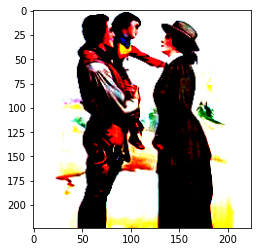

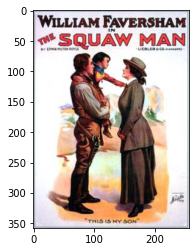

In [5]:
print('Data size: %d samples' % len(valset))

sample_movieID = 4
img, text, text_mask, labels = valset[sample_movieID]
#print(text)
#print(text_mask)

print(valset.tokenizer.convert_ids_to_tokens(text.numpy().tolist()))
#print(val_data.tokenizer.convert_ids_to_tokens([100,0,1,2,3,4,5,6,7,8,9,10,101,102,103,104,105,106,107]))

labels = labels.numpy()
# Is there a better way to do this?
print([valset.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

plt.imshow(img.permute(1, 2, 0))
plt.show()

img_original = valset.load_image_only(sample_movieID)
plt.imshow(img_original)
plt.show()

In [6]:
num_categories = len(trainset.categories)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_text = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)
model_text.load_state_dict(torch.load('best_model_mmu.pth', map_location=device))
model_text.eval()

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
from torchvision import models
import torch.nn as nn
cnn_model = models.resnet18(pretrained=True) # weights optimized for ImageNet data
for param in cnn_model.parameters(): # freezing parameters 
  param.requires_grad = False

num_ftrs = cnn_model.fc.in_features # getting number of input features from last layer
cnn_model.fc = nn.Linear(num_ftrs, num_categories) # creating new fully connected layer

cnn_model = cnn_model.to(device) # sending model to device
cnn_model.load_state_dict(torch.load('best_img_model.pth', map_location=device))
cnn_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
img, text, text_mask, labels = valset[sample_movieID]
predictions_text = model_text(text.unsqueeze(0), text_mask.unsqueeze(0))
print(predictions_text.logits.shape)

predictions_image = cnn_model(img.unsqueeze(0).to(device))
print(predictions_image.shape)

torch.Size([1, 27])
torch.Size([1, 27])


In [8]:
_, (imgs, texts, text_masks, labels) = next(enumerate(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

predictions_text = model_text(texts, text_masks)
print(predictions_text.logits.shape)

predictions_image = cnn_model(imgs.to(device))
print(predictions_image.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])
torch.Size([10, 27])
torch.Size([10, 27])


In [12]:
predictions_text.logits=predictions_text.logits.to("cpu")
predictions_image=predictions_image.to("cpu")
imgs=imgs.to("cpu")
texts=texts.to("cpu")
text_masks=text_masks.to("cpu")
labels=labels.to("cpu")

In [23]:
#evaluate single modal 
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    #print(predicted.data.sigmoid())
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    #print(pred_vals)
    #print(true_vals)
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

def f_score(predicted, labels):
    #print(predicted)
    #print(predicted.data.sigmoid())
    pred_vals = predicted.data.sigmoid() > 0.5
    #print(pred_vals)
    #print(labels)
    true_positive = ((pred_vals==1) & (pred_vals == labels)).sum(dim = 1)
    false_positive = ((pred_vals==1) & (pred_vals != labels)).sum(dim = 1)
    false_negative = ((pred_vals==0) & (pred_vals != labels)).sum(dim = 1)
    f_score = true_positive/(true_positive+(false_positive+false_negative)/2)
    return f_score
"""
print("accuracy")
a = top5_accuracy(predictions_text.logits,labels)
print(a)

print("fscore")
f_score = f_score(predictions_text.logits,labels)
#print(tp)
#print(fp)
#print(fn)
print(f_score)
"""


#def get_accuracies(data_loader, img_model, text_model):
cnn_model.eval()
model_text.eval()
cnn_model.to(device)
model_text.to(device)
cumulative_accuracy_img = 0
cumulative_fscore_img = 0
cumulative_accuracy_text = 0
cumulative_fscore_text = 0

num_samples = 0
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(test_loader):
  imgs = imgs.cuda()
  texts = texts.cuda()
  text_masks = text_masks.cuda()
  labels = labels.cuda()

  predictions_text = model_text(texts, text_masks)
  predictions_image = cnn_model(imgs)
  cumulative_accuracy_img += top5_accuracy(predictions_image, labels).sum().item()
  f_s = f_score(predictions_image,labels)
  cumulative_fscore_img+=f_s.sum().item()

  cumulative_accuracy_text += top5_accuracy(predictions_text.logits, labels).sum().item()
  f_s = f_score(predictions_text.logits,labels)
  cumulative_fscore_text+=f_s.sum().item()
  num_samples += texts.size(0)
print("Image Accuracy: ", cumulative_accuracy_img/num_samples)
print("Image Fscore: ", cumulative_fscore_img/num_samples)
print("Text Accuracy: ", cumulative_accuracy_text/num_samples)
print("Text Fscore: ", cumulative_fscore_text/num_samples)


#get_accuracies(train_loader,cnn_model,model_text)



Image Accuracy:  0.7310680985404889
Image Fscore:  0.21755414823642646
Text Accuracy:  0.7259392335424363
Text Fscore:  0.4294423646904869


In [25]:
def get_distribution(data_loader):
  sum = torch.zeros(1,num_categories)
  for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(data_loader):
    sum+=(labels.sum(dim=0))
  print(sum)
print(trainset.categories)
print("Training Genres")
get_distribution(train_loader)
print("Validation Genres")
get_distribution(val_loader)
print("Testing Genres")
get_distribution(test_loader)


['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
Training Genres
tensor([[2.1550e+03, 0.0000e+00, 1.6110e+03, 5.8600e+02, 7.8800e+02, 5.1080e+03,
         2.2930e+03, 1.2340e+03, 8.4240e+03, 9.7800e+02, 1.1620e+03, 2.0200e+02,
         6.8000e+02, 1.6030e+03, 6.3400e+02, 5.0300e+02, 1.2310e+03, 3.9000e+01,
         1.0000e+00, 3.2260e+03, 1.2120e+03, 2.8100e+02, 3.7900e+02, 2.0000e+00,
         3.1130e+03, 8.0600e+02, 4.2300e+02]])
Validation Genres
tensor([[ 351.,    3.,  278.,  105.,  144.,  873.,  382.,  219., 1401.,  172.,
          186.,   34.,  118.,  275.,  100.,   85.,  209.,    6.,    0.,  548.,
          193.,   48.,   64.,    0.,  512.,  128.,   72.]])
Testing Genres
tensor([[1.0440e+03, 1.0000e+00, 8.2100e+02, 3.0600e+02, 4.1100e+02, 2

In [53]:
class MultimodalClassifier(torch.nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # Why being conservative? Let's just pick the deepest,
        # biggest model available. This is a small dataset after all,
        # and we have a GPU available thanks to Google Colab. 
        # Wide-Resnet101 has 101 layers deep and double the width of the regular
        # Resnet-101 model.
        # ResNext 101 is also incredibly large and intensive.
        num_categories = 27
        self.combine_linear = torch.nn.Linear(num_categories*2, num_categories)
        #self.combine_linear_2 = torch.nn.Linear(num_categories*2, num_categories*2)
        #self.combine_linear_3 = torch.nn.Linear(num_categories*2, num_categories)


    def forward(self, image_out, text_out):
        # I don't want to tune the parameters.
        # I tried tuning but didn't work better so disabling gradients
        # and putting the pretrained network in eval mode.
        #with torch.no_grad():
        #    self.pretrained.eval()
        #y = torch.sigmoid(self.combine_linear(torch.cat( (image_out,text_out),dim=1 )))
        #a = torch.sigmoid(self.combine_linear_2(y))
        #b = self.combine_linear_3(a)
        y = self.combine_linear(torch.cat( (image_out,text_out),dim=1 ))
        return y

In [56]:
from livelossplot import PlotLosses
from transformers import AdamW  # optimizer that comes with this library.
from transformers import get_linear_schedule_with_warmup
num_epochs = 20
cnn_model.eval()
model_text.eval()
multi_model = MultimodalClassifier()
multi_model.to(device)
optimizer = AdamW(multi_model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

_, (imgs, texts, text_masks, labels) = next(enumerate(val_loader))
multi_model.eval()
imgs = imgs.cuda()
texts = texts.cuda()
text_masks = text_masks.cuda()
labels = labels.cuda()
predictions_text = model_text(texts, text_masks)
predictions_image = cnn_model(imgs)
predicted = multi_model(predictions_image, predictions_text.logits)
print(predicted.shape)

torch.Size([10, 27])


In [34]:
!pip -q install livelossplot

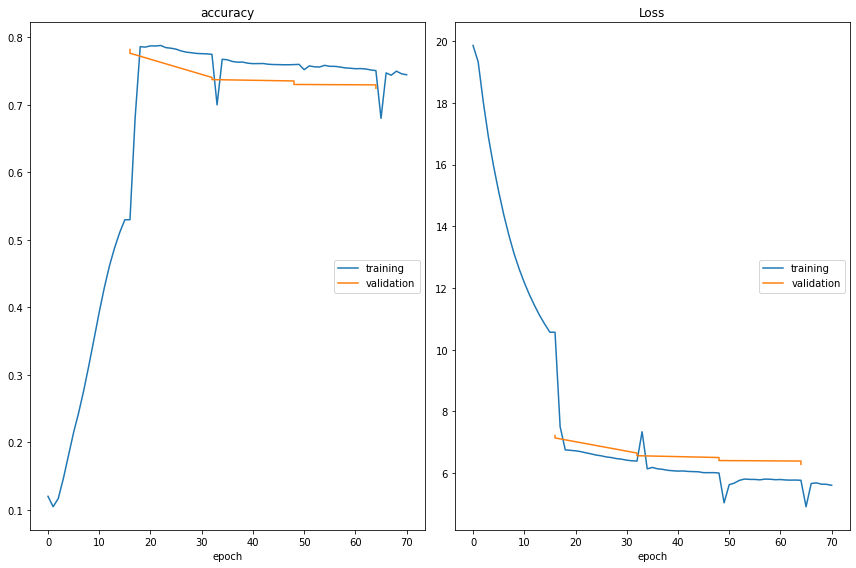

accuracy
	training         	 (min:    0.105, max:    0.788, cur:    0.745)
	validation       	 (min:    0.725, max:    0.782, cur:    0.725)
Loss
	training         	 (min:    4.913, max:   19.860, cur:    5.608)
	validation       	 (min:    6.289, max:    7.221, cur:    6.289)


KeyboardInterrupt: ignored

In [57]:
# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    print(epoch)
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    multi_model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        imgs = imgs.cuda()
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        
        predictions_text = model_text(texts, text_masks)
        predictions_image = cnn_model(imgs)
        predicted = multi_model(predictions_image, predictions_text.logits)
        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        multi_model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    multi_model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        imgs = imgs.cuda()
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predictions_text = model_text(texts, text_masks)
        predictions_image = cnn_model(imgs)
        predicted = multi_model(predictions_image, predictions_text.logits)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(multi_model.state_dict(), 'best_model_so_far_multimodal.pth') 

In [59]:
cnn_model.eval()
model_text.eval()
multi_model.eval()
cnn_model.to(device)
model_text.to(device)
multi_model.to(device)
cumulative_accuracy = 0
cumulative_fscore = 0


num_samples = 0
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(test_loader):
  imgs = imgs.cuda()
  texts = texts.cuda()
  text_masks = text_masks.cuda()
  labels = labels.cuda()

  predictions_text = model_text(texts, text_masks)
  predictions_image = cnn_model(imgs)
  predicted = multi_model(predictions_image, predictions_text.logits)
  cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
  f_s = f_score(predicted,labels)
  cumulative_fscore+=f_s.sum().item()
  num_samples += texts.size(0)
print("MultiModal Accuracy: ", cumulative_accuracy/num_samples)
print("MultiModal Fscore: ", cumulative_fscore/num_samples)

MultiModal Accuracy:  0.7275035368783274
MultiModal Fscore:  0.3072854350516239
